In [1]:
!pip install pygimli tetgen
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.



# 2D Refraction modelling and inversion

This example shows how to use the TravelTime manager to generate the response
of a three-layered sloping model and to invert the synthetic noisified data.


In [3]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt
import matplotlib.pyplot as plt

from latex import latexify
latexify(columns=2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Model setup
We start by creating a three-layered slope (The model is taken from the BSc
thesis of Constanze Reinken conducted at the University of Bonn).



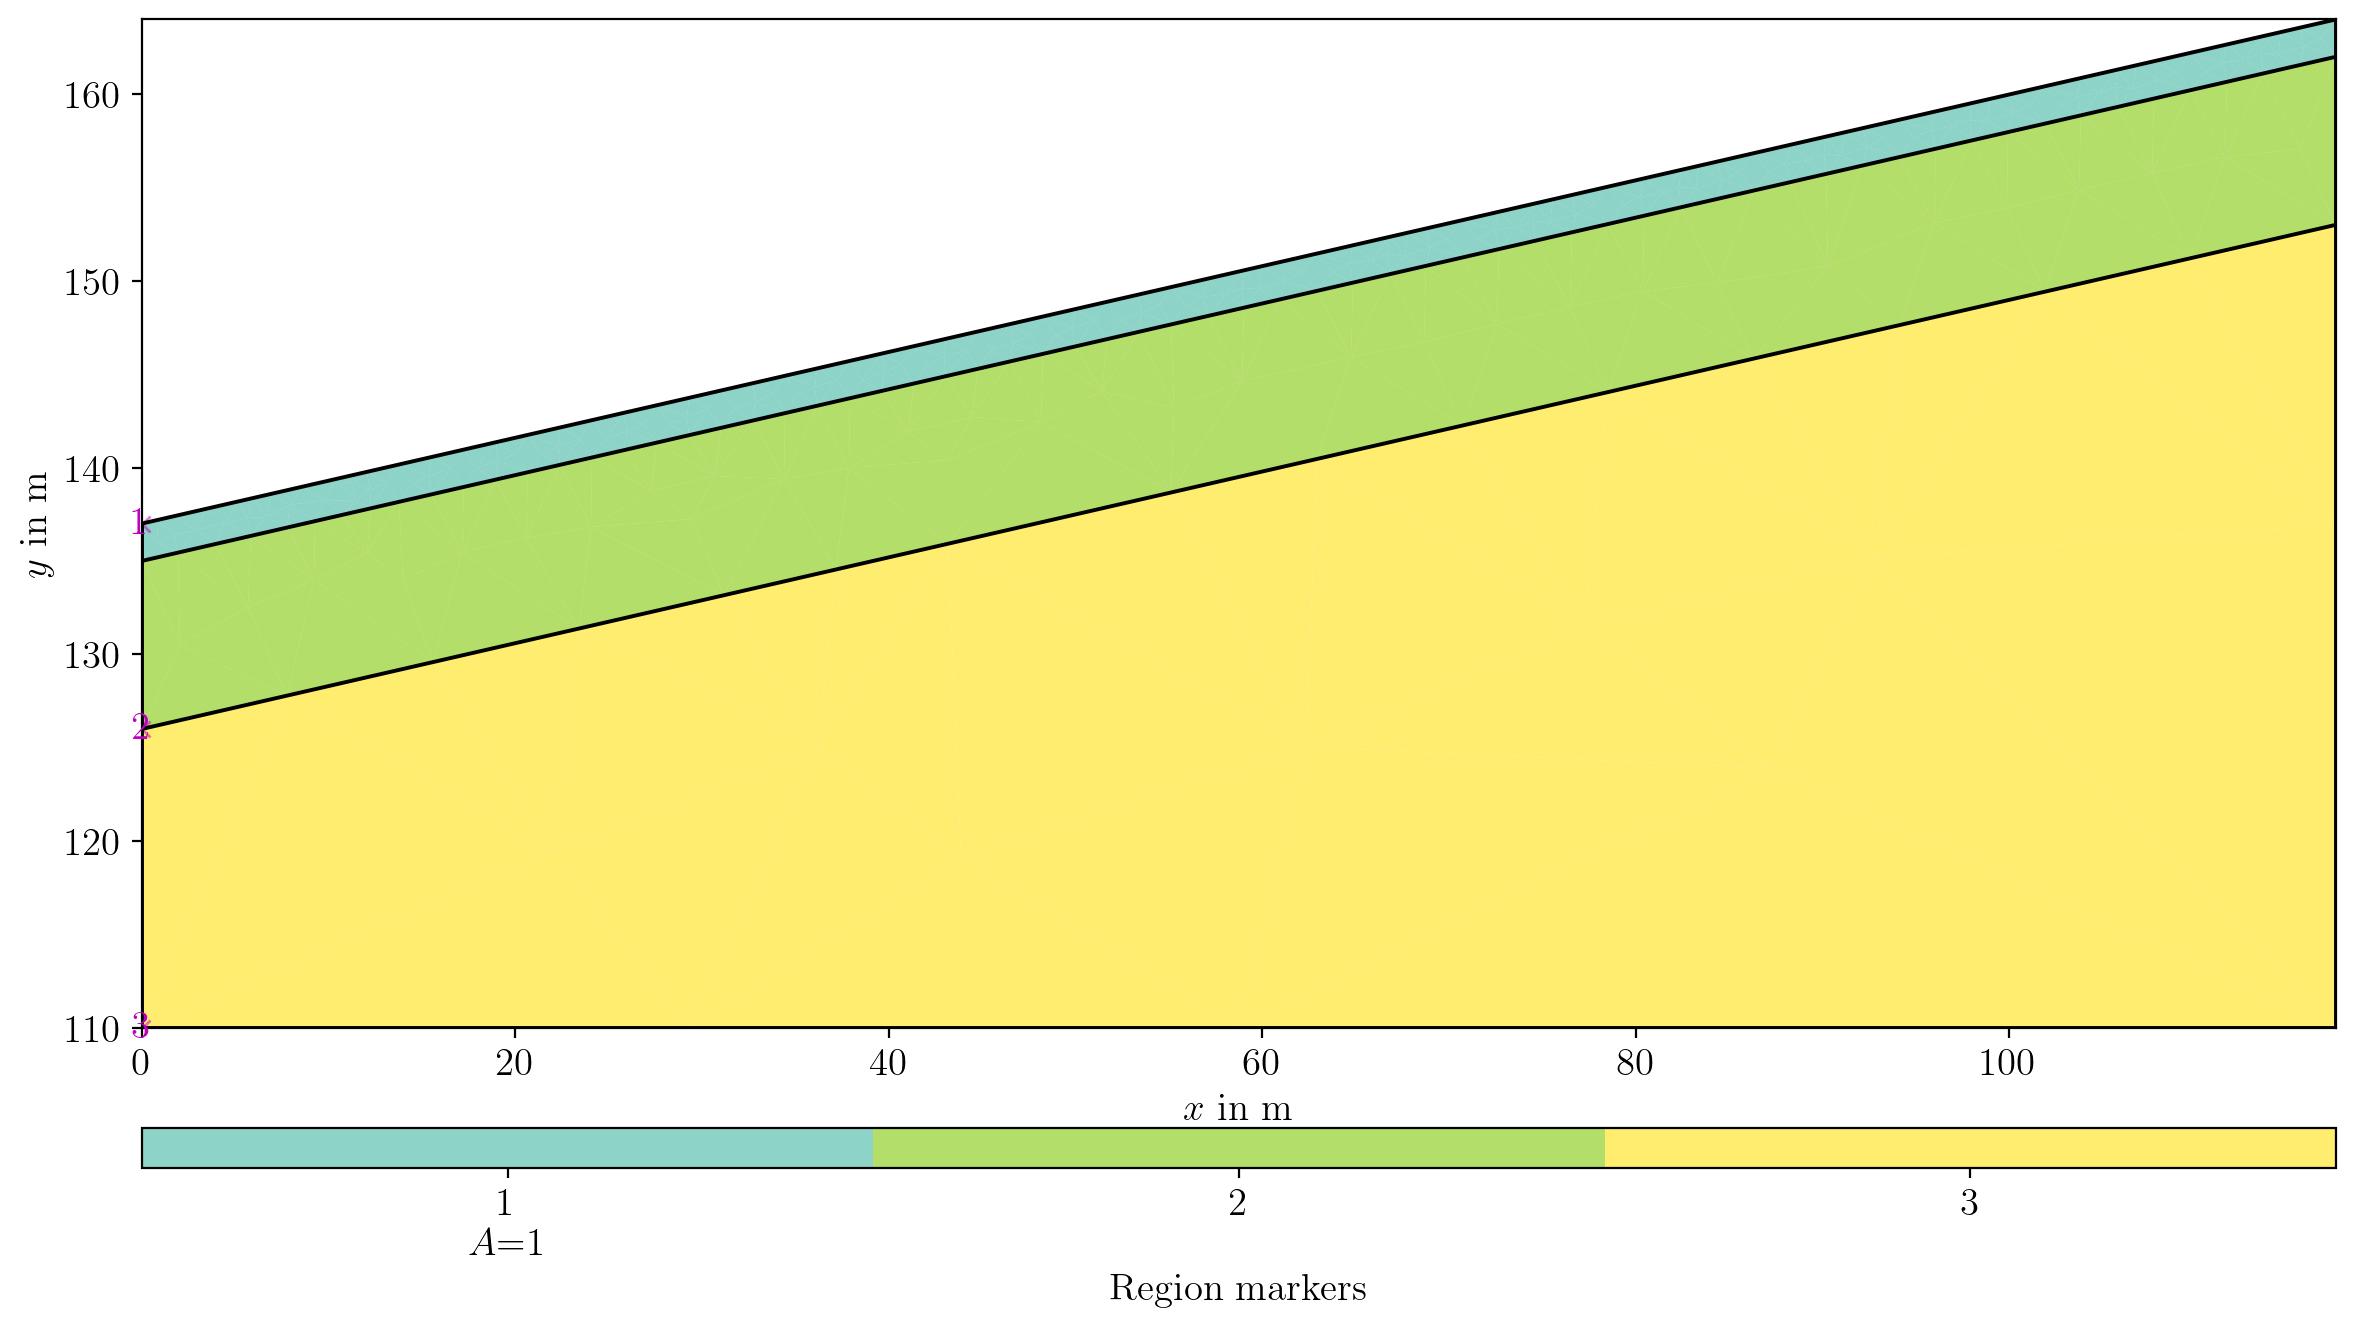

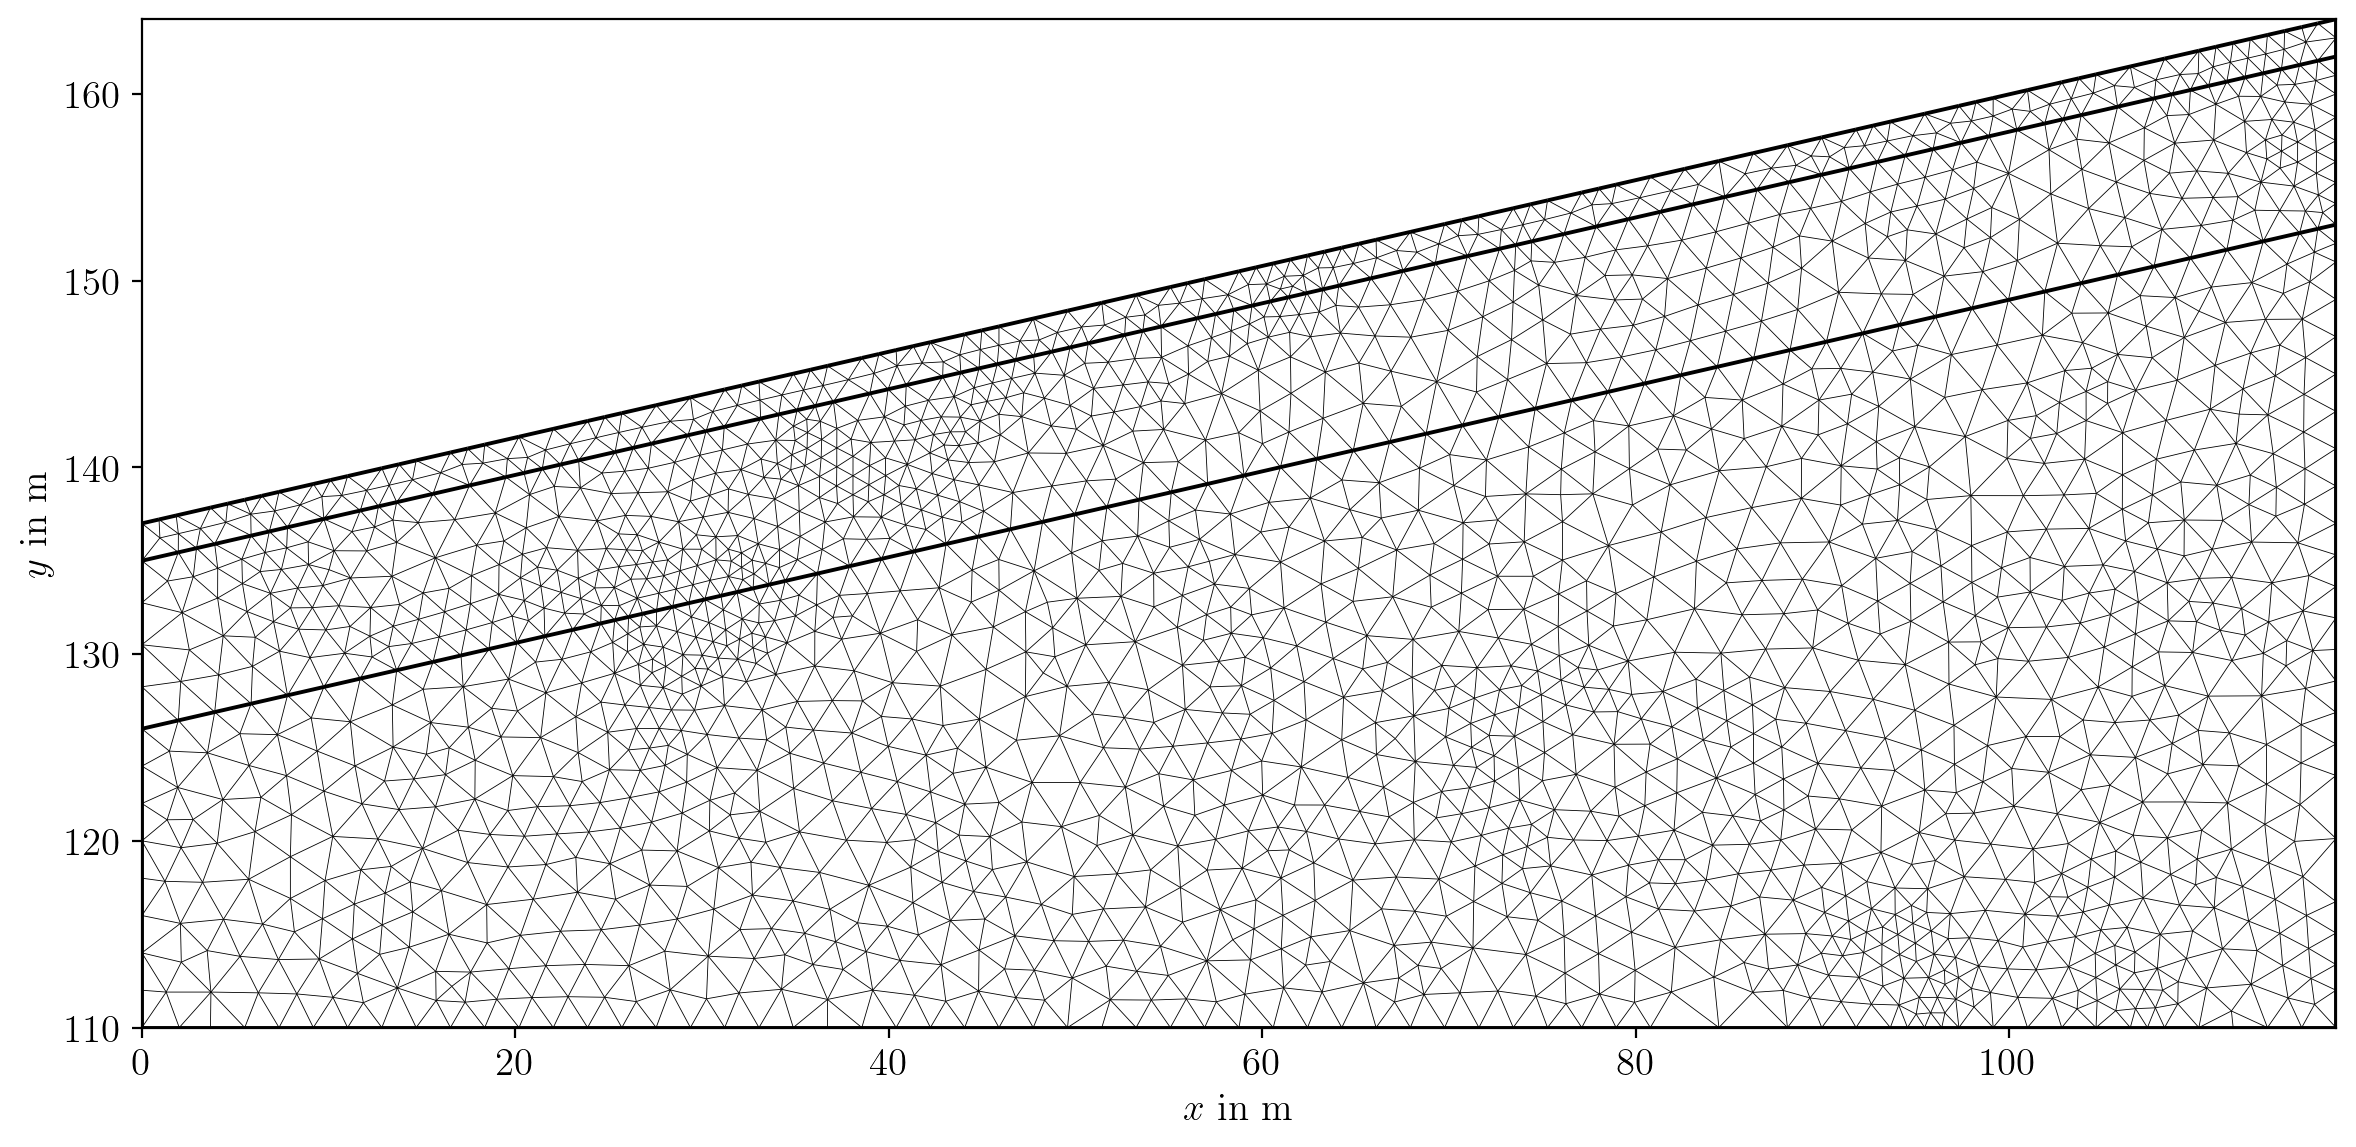

In [28]:
layer1 = mt.createPolygon([[0.0, 137], [117.5, 164], [117.5, 162], [0.0, 135]],
                          isClosed=True, marker=1, area=1)
layer2 = mt.createPolygon([[0.0, 126], [0.0, 135], [117.5, 162], [117.5, 153]],
                          isClosed=True, marker=2)
layer3 = mt.createPolygon([[0.0, 110], [0.0, 126], [117.5, 153], [117.5, 110]],
                          isClosed=True, marker=3)

geom = layer1 + layer2 + layer3

fig, ax = plt.subplots(figsize=(12, 8))
pg.show(geom, ax=ax)
plt.show()

mesh = mt.createMesh(geom, quality=34.3, area=3, smooth=[1, 10])
fig, ax = plt.subplots(figsize=(12, 8))
ax, _ = pg.show(mesh, ax=ax)
plt.show()

Next we define geophone positions and a measurement scheme, which consists of
shot and receiver indices.



In [6]:
numberGeophones = 48
sensors = np.linspace(0., 117.5, numberGeophones)
scheme = tt.createRAData(sensors, shotDistance=3)

# Adapt sensor positions to slope
slope = (164 - 137) / 117.5
pos = np.array(scheme.sensors())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = x * slope + 137
    pos[i, 1] = new_y

scheme.setSensors(pos)

## Synthetic data generation
Now we initialize the TravelTime manager and asssign P-wave velocities to the
layers. To this end, we create a map from cell markers 0 through 3 to
velocities (in m/s) and generate a velocity vector. To check whether the
model looks correct, we plot it along with the sensor positions.



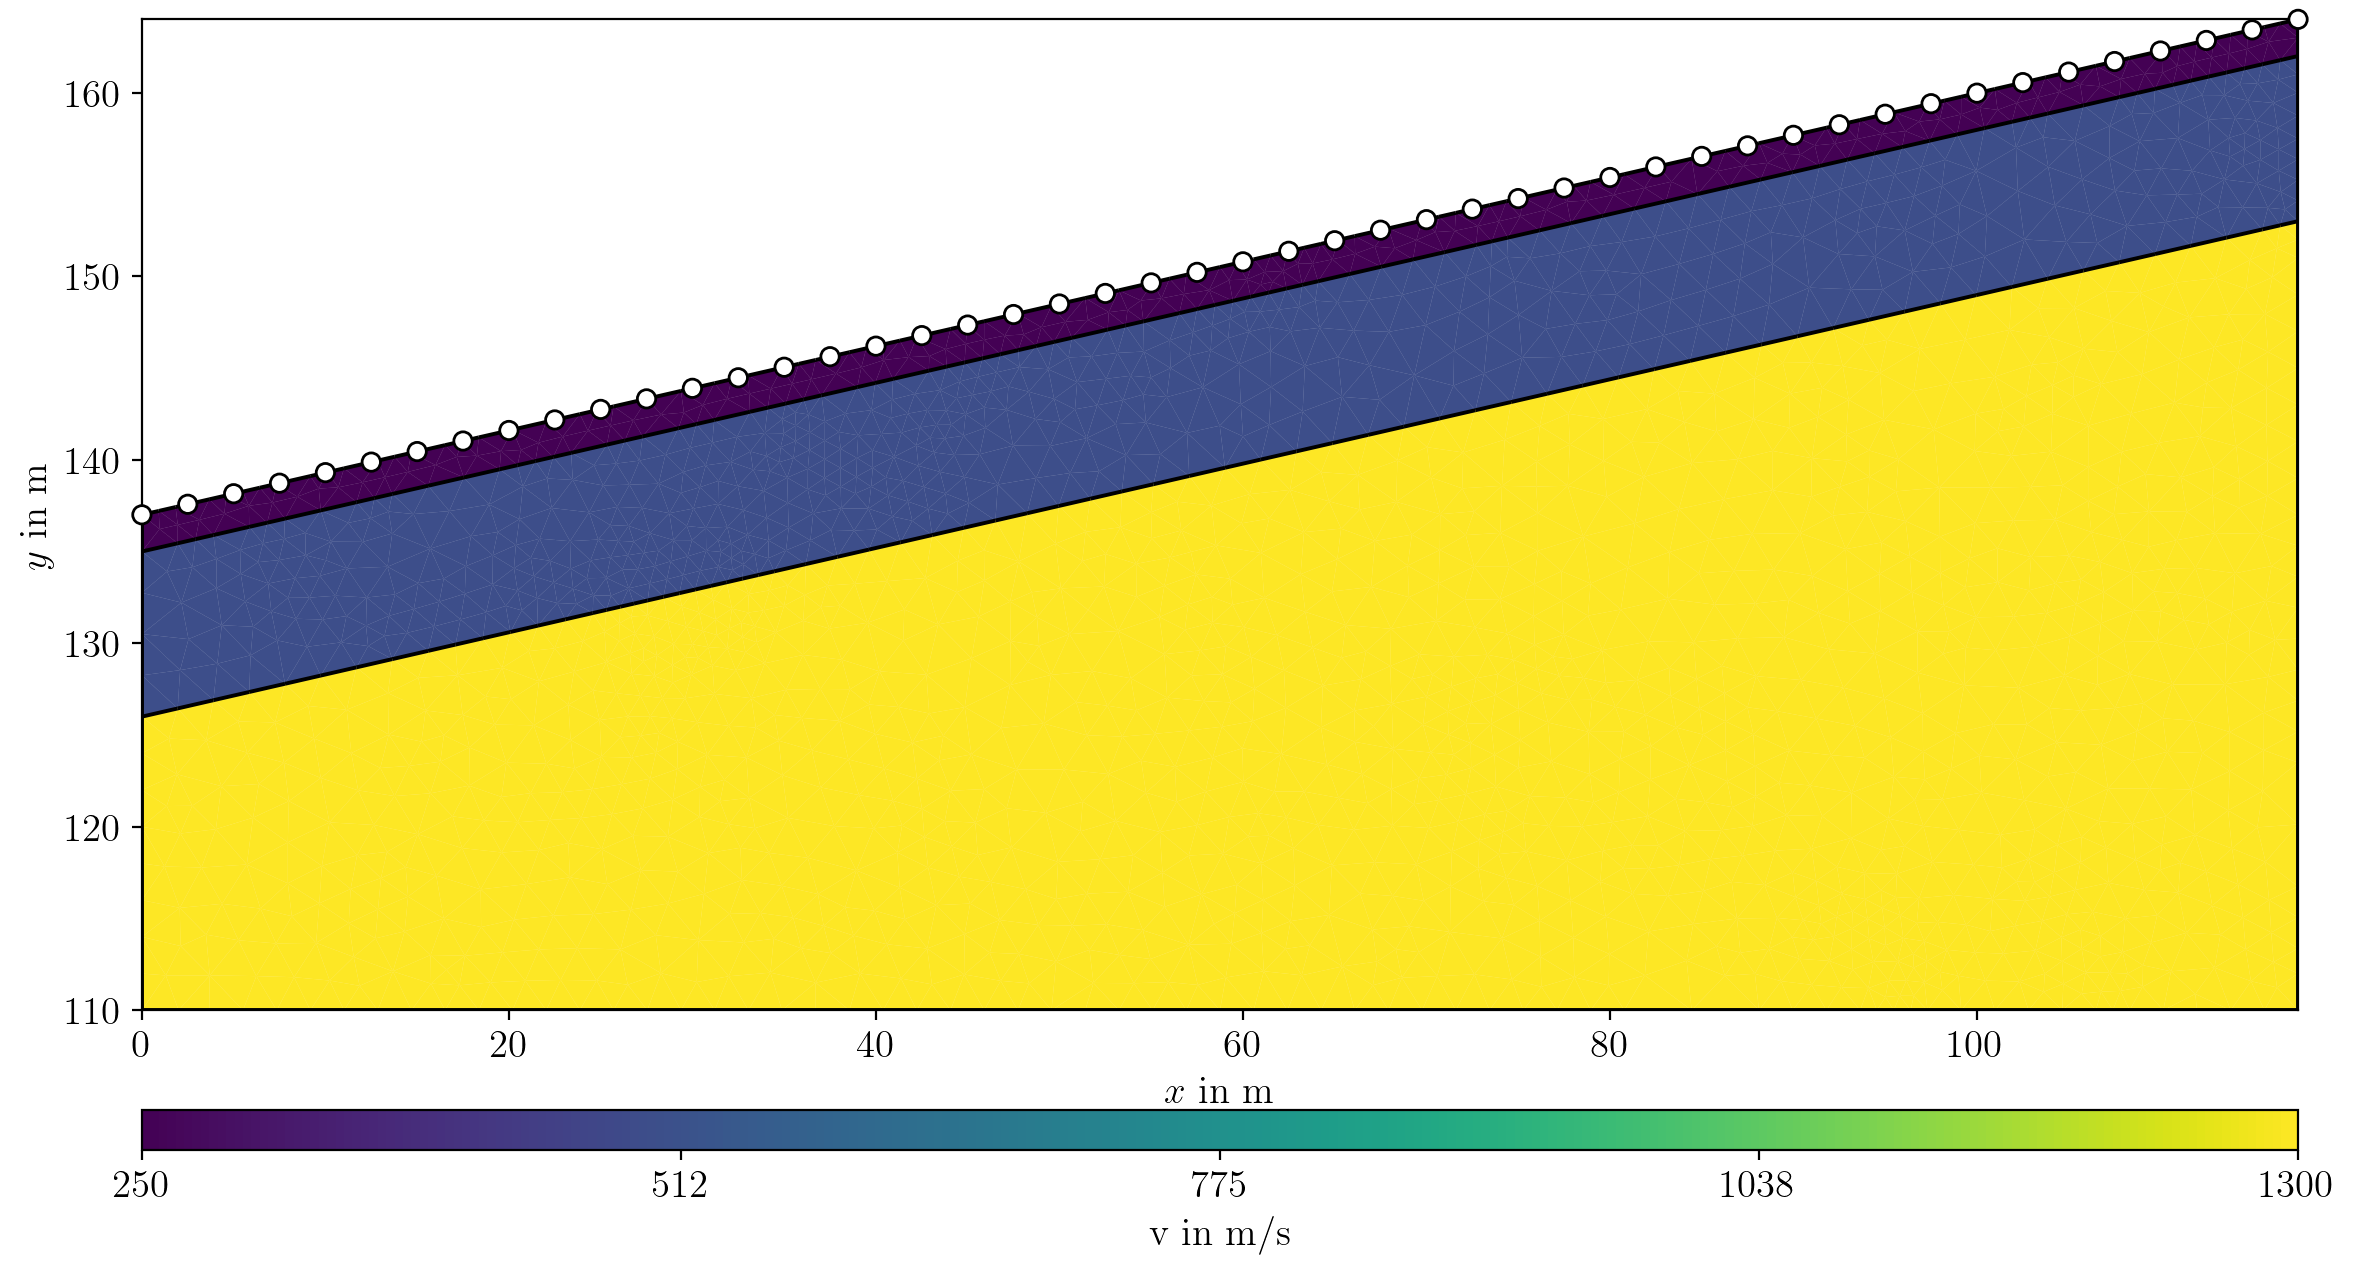

In [7]:
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 250
vp[vp == 2] = 500
vp[vp == 3] = 1300

fig, ax = plt.subplots(figsize=(12, 8))
ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s', ax=ax)
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=1.0,
                         facecolor='white', edgecolor='black')

We use this model to create noisified synthetic data and look at the
traveltime data matrix. Note, we force a specific noise seed as we want
reproducable results for testing purposes.



INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
30/10/25 - 19:57:19 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.008790995543598544 0.14101993727141837


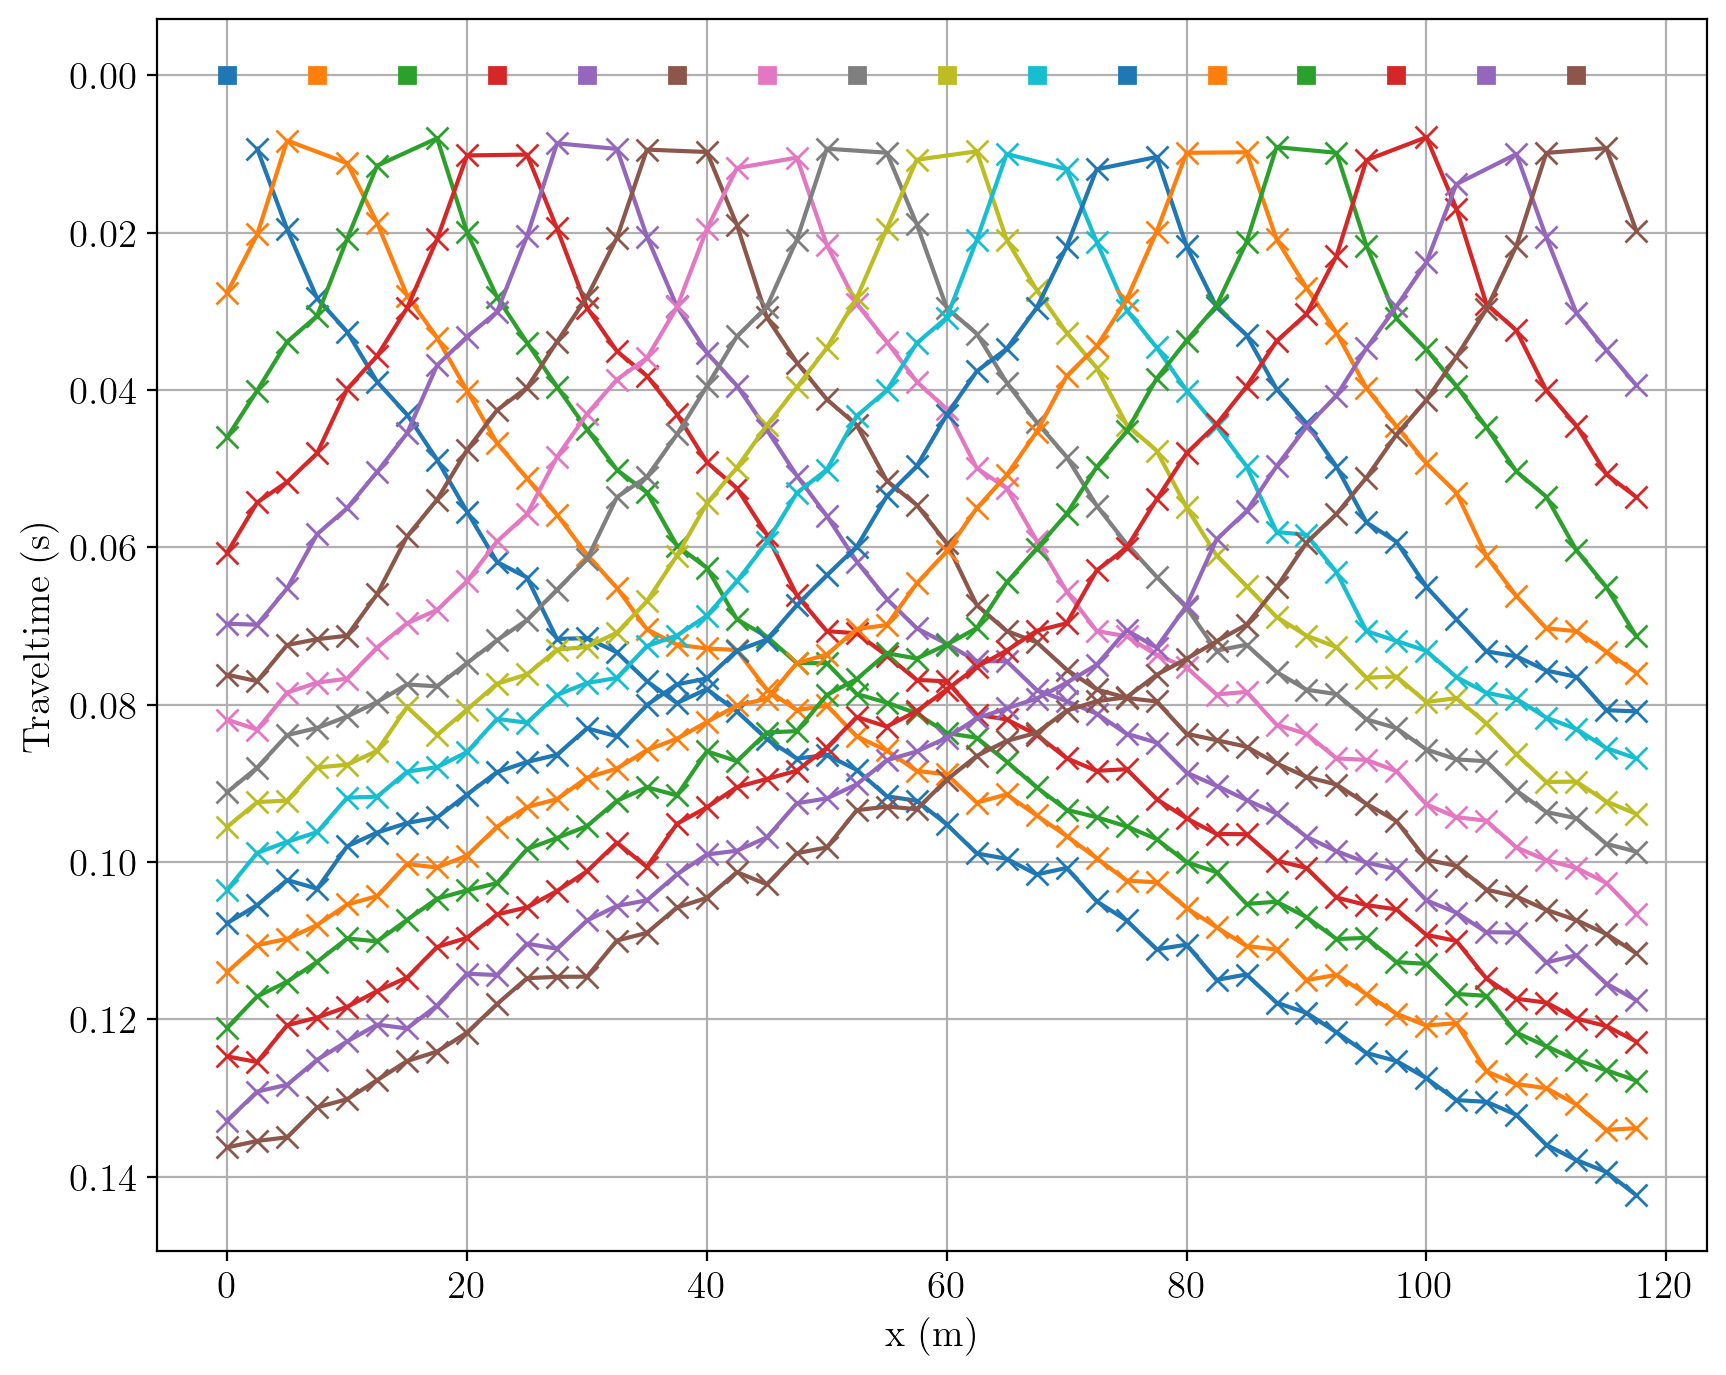

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
data = tt.simulate(slowness=1.0 / vp, scheme=scheme, mesh=mesh,
                   noiseLevel=0.001, noiseAbs=0.001, seed=1337, verbose=True)
tt.show(data, ax=ax)

## Inversion
Now we invert the synthetic data. We need a new independent mesh without
information about the layered structure. This mesh can be created manual or
guessd automatic from the data sensor positions (in this example). We
tune the maximum cell size in the parametric domain to 15m²



In [9]:
mgr = tt.TravelTimeManager(data)
vest = mgr.invert(secNodes=2, paraMaxCellSize=15.0,
                  maxIter=10, verbose=True)
np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

INFO:pyGIMLi:Found 1 regions.
30/10/25 - 19:57:37 - pyGIMLi - INFO - Found 1 regions.
INFO:pyGIMLi:Found 1 regions.
30/10/25 - 19:57:37 - pyGIMLi - INFO - Found 1 regions.
INFO:pyGIMLi:Creating forward mesh from region infos.
30/10/25 - 19:57:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
30/10/25 - 19:57:37 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
INFO:pyGIMLi:Create gradient starting model. 500: 5000
30/10/25 - 19:57:37 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
INFO:pyGIMLi:Created startmodel from forward operator:1198, min/max=0.000200/0.002000
30/10/25 - 19:57:37 - pyGIMLi - INFO - Created startmodel from forward operator:1198, min/max=0.000200/0.002000
INFO:pyGIMLi:Starting inversion.
30/10/25 - 19:57:37 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f2409948fe0>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 0.0079/0.14
min/max (error): 0.8%/12.81%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  626.79
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    3.26 (dPhi = 99.39%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.93 (dPhi = 37.34%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.35 (dPhi = 22.91%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.09 (dPhi = 15.24%) lam: 20.0
------------------------------------------------------------------

The manager also holds the method showResult that is used to plot the result.
Note that only covered cells are shown by default.
For comparison we plot the geometry on top.



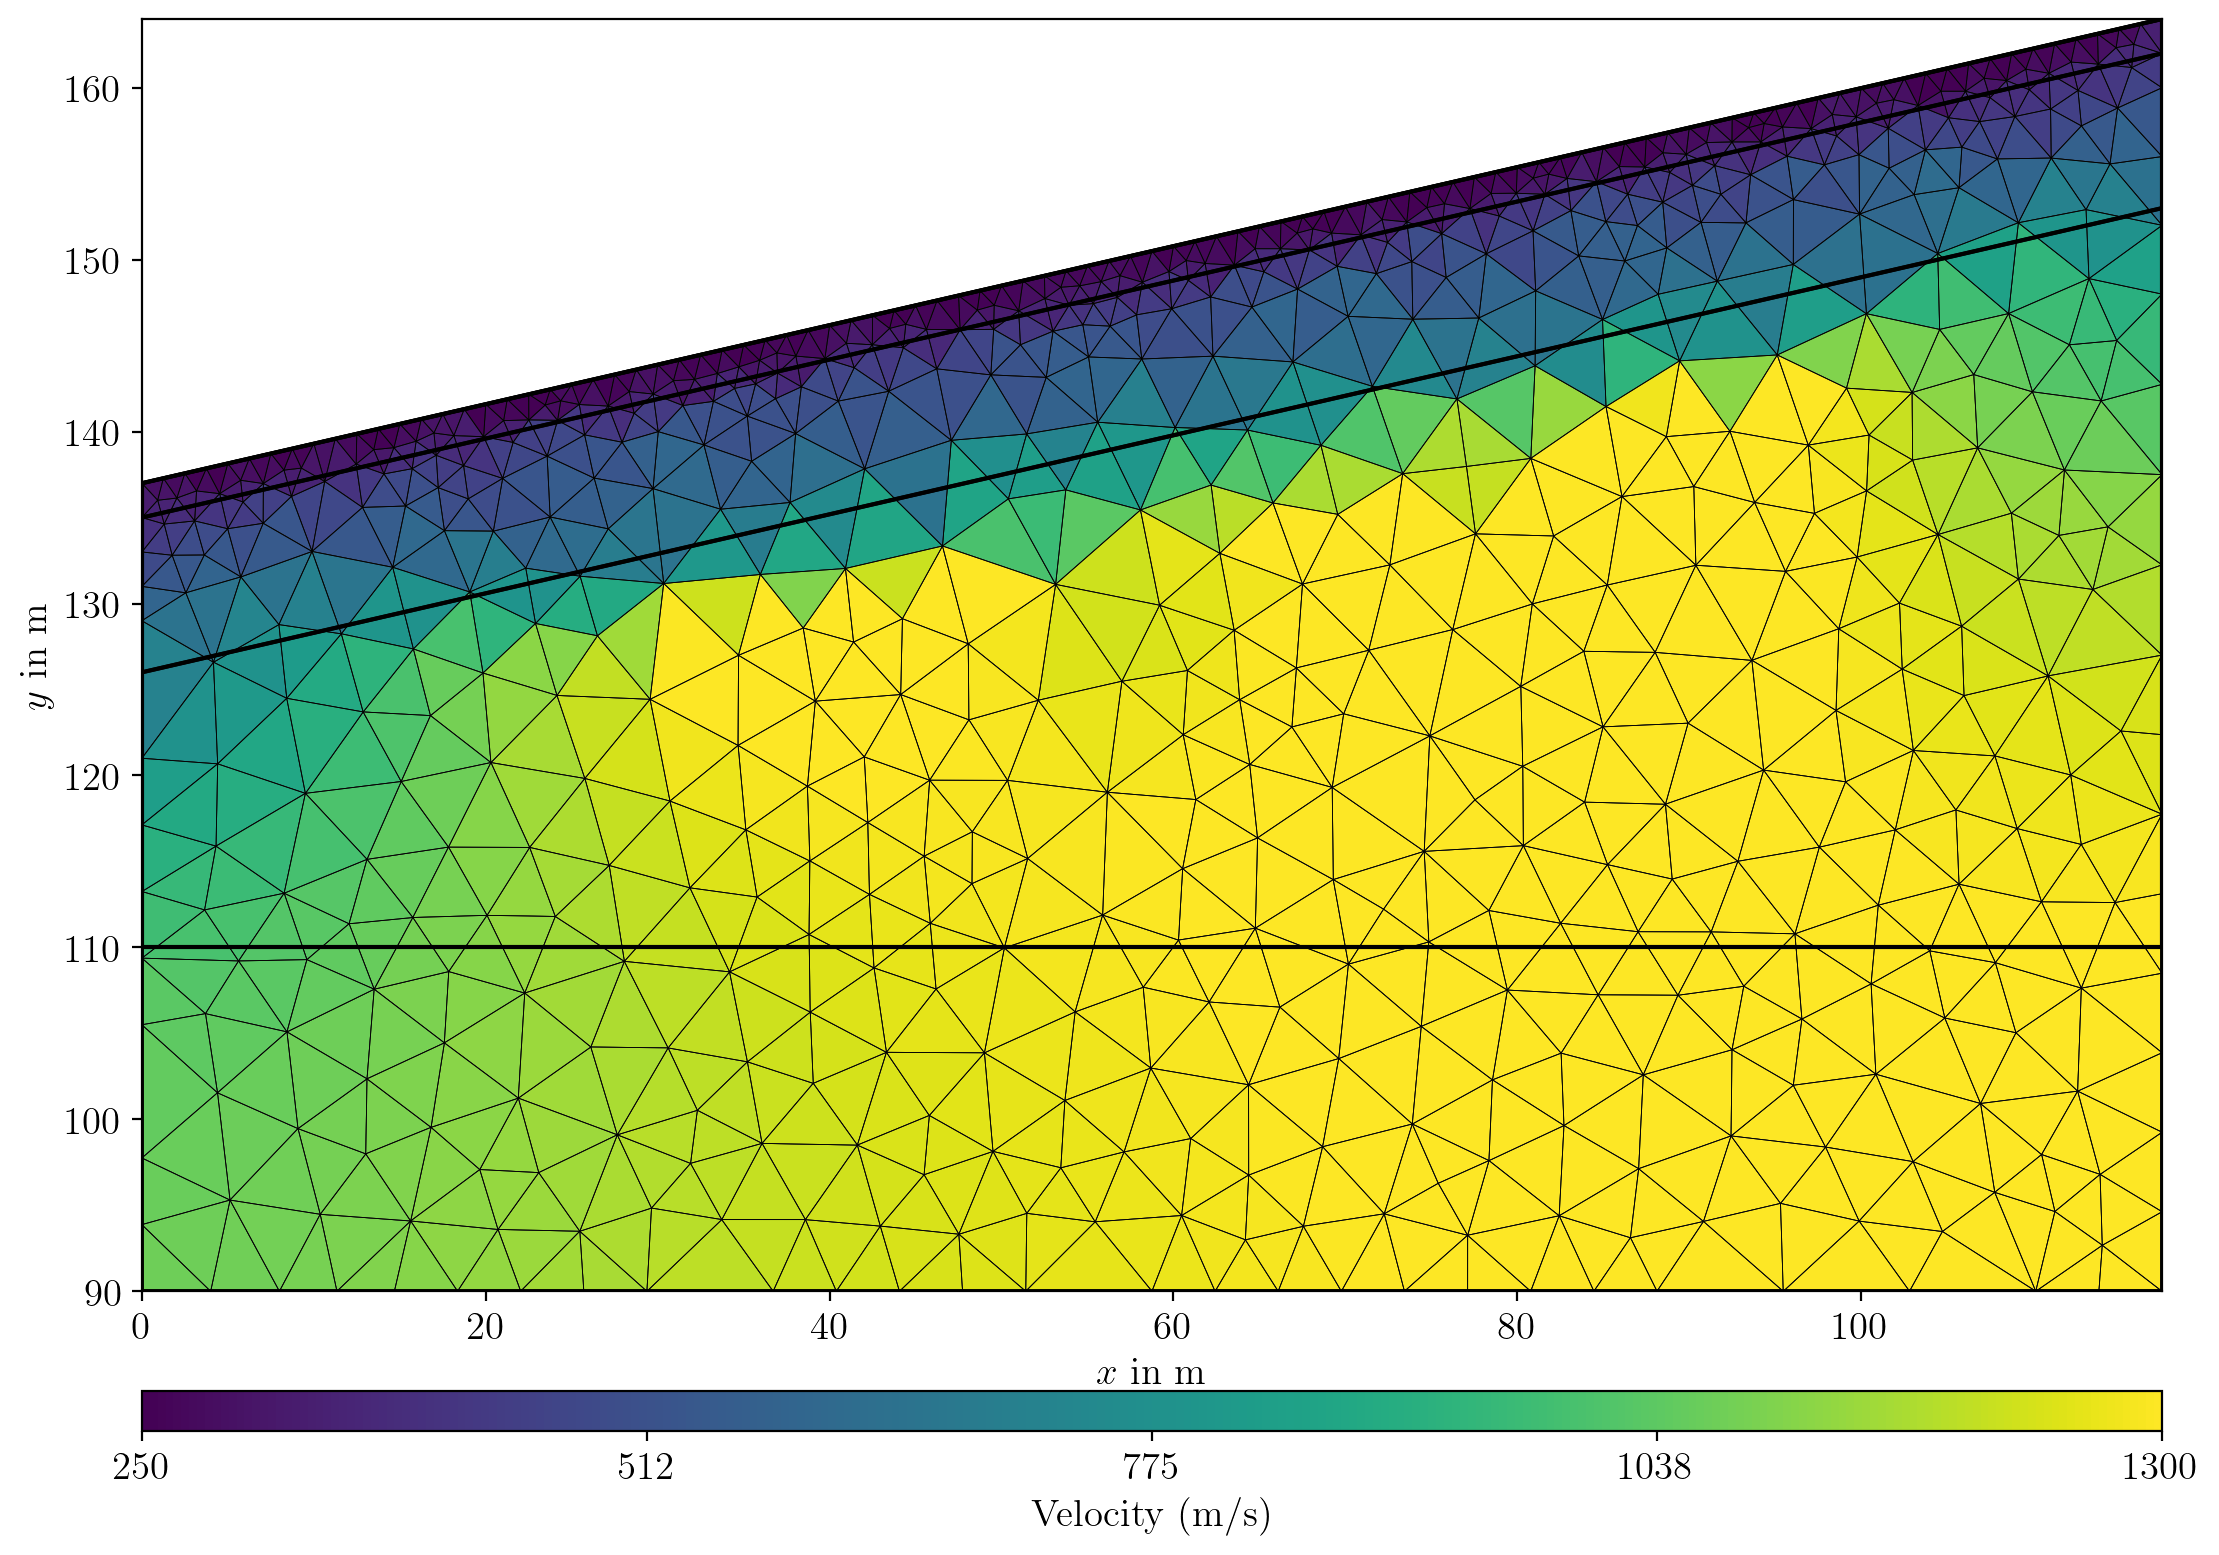

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
ax, _ = mgr.showResult(cMin=min(vp), cMax=max(vp), showMesh=True, logScale=False, ax=ax)
ax, _ = pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)

Note that internally the following is called

```python
ax, _ = pg.show(ra.mesh, vest, label="Velocity [m/s]", **kwargs)
```


It is always important to have a look at the data fit.



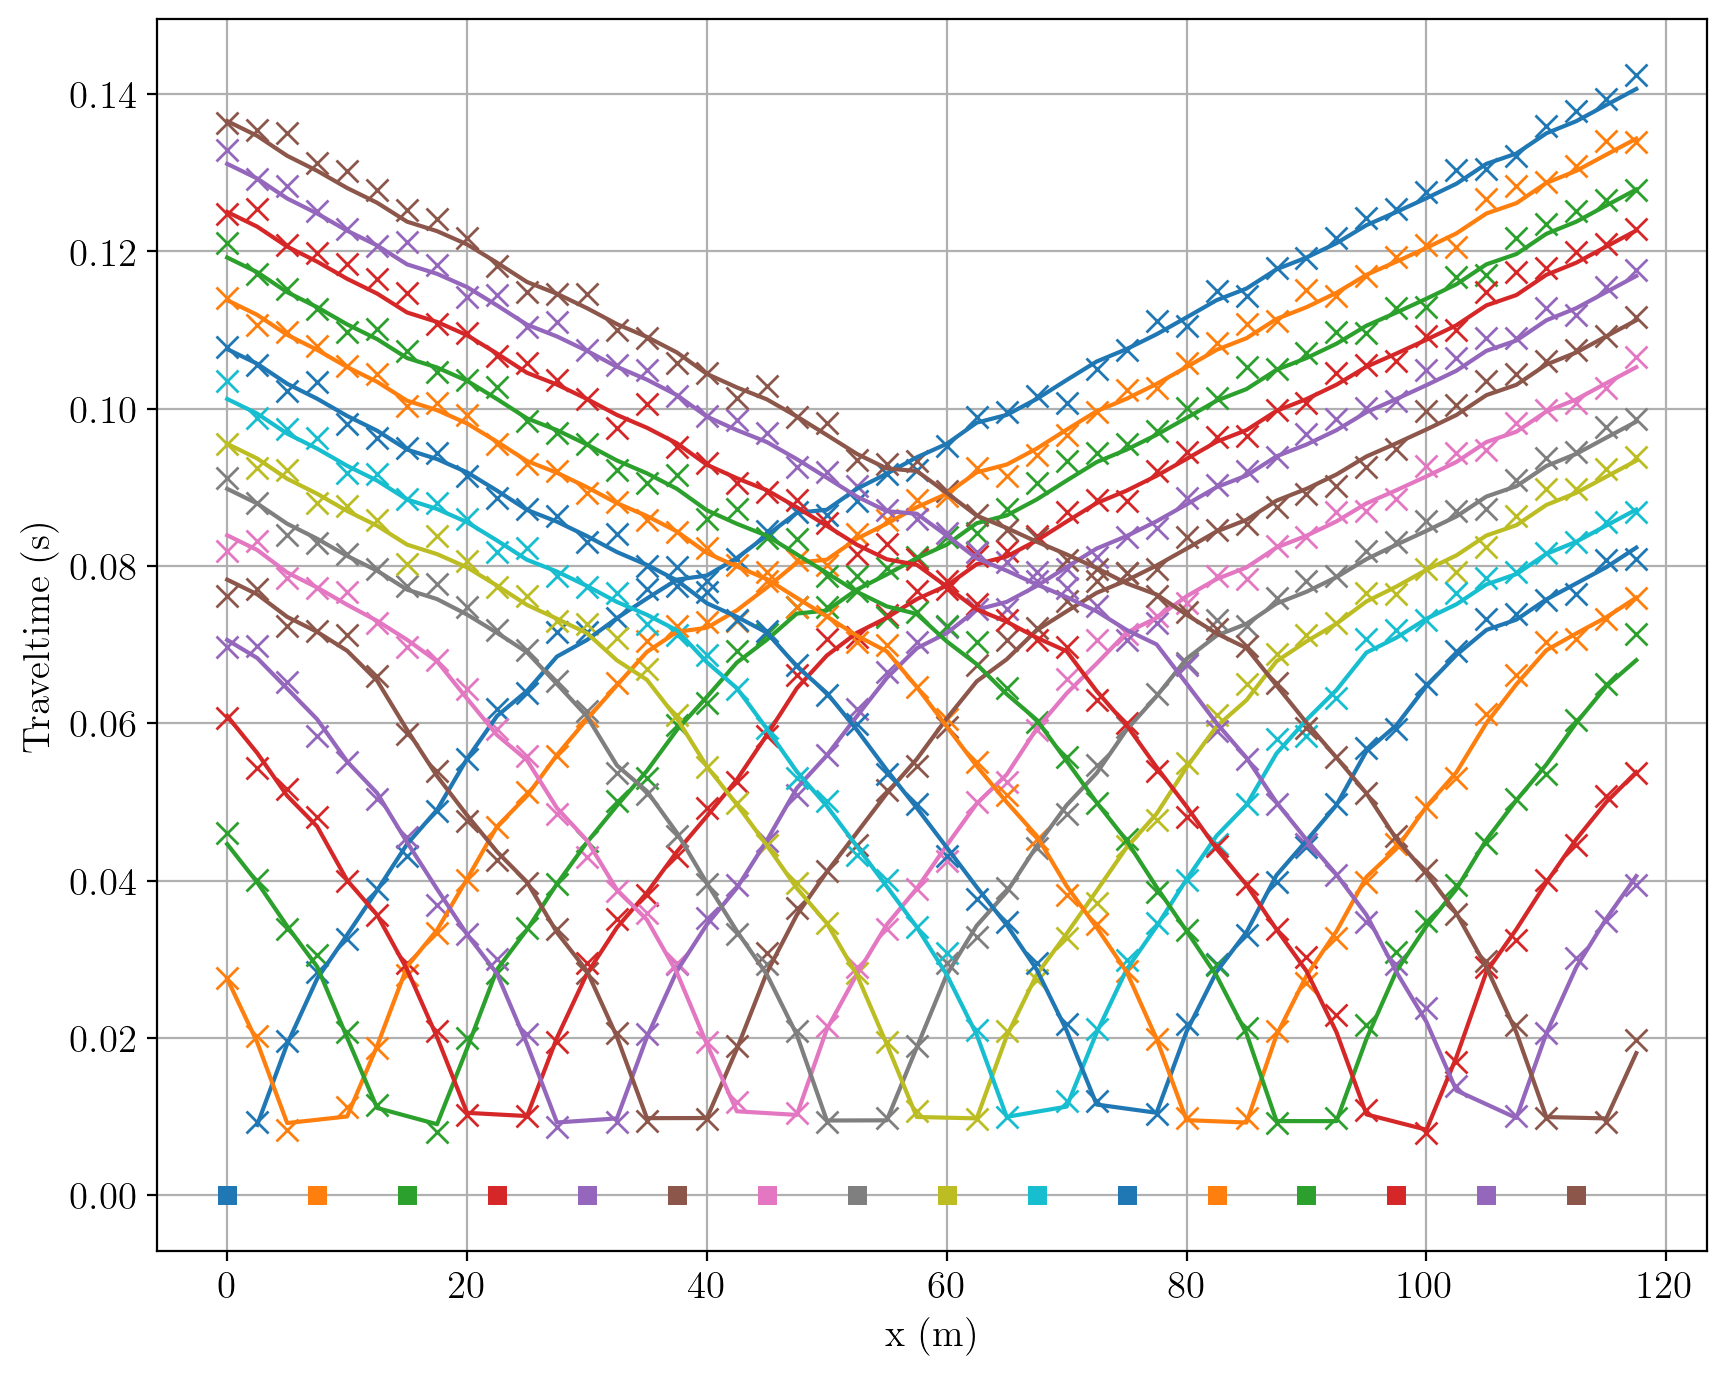

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
mgr.showFit(firstPicks=True, ax=ax)

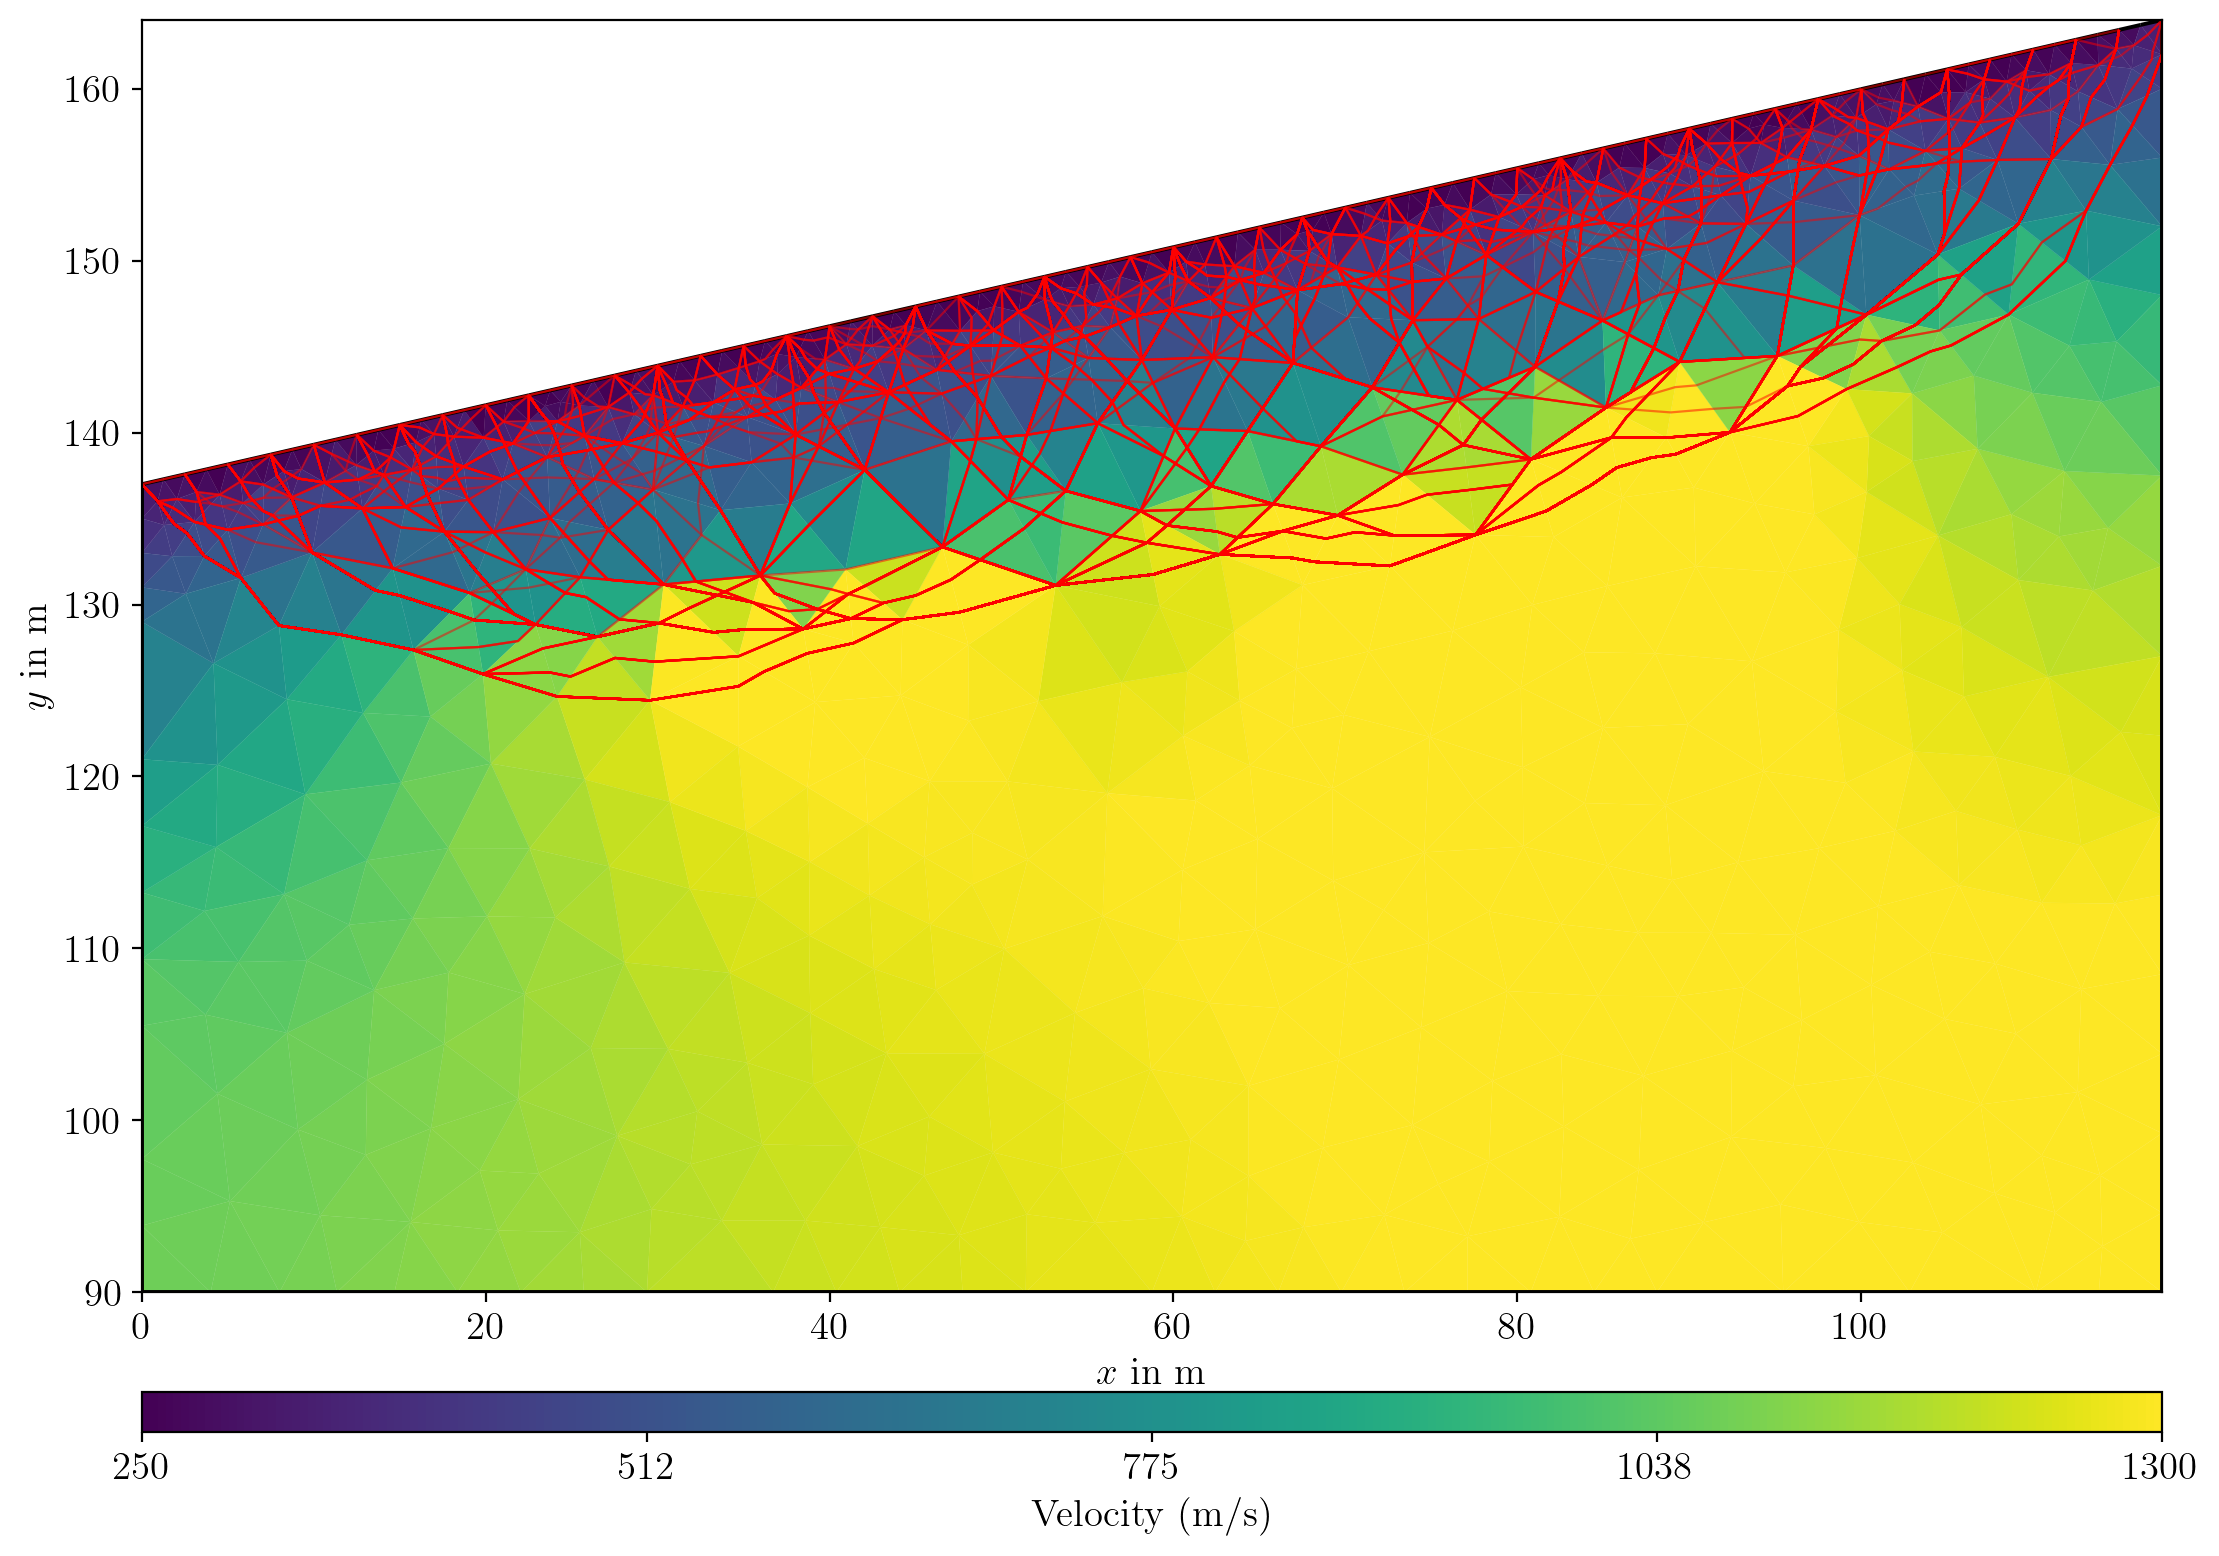

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
ax, cbar = mgr.showResult(logScale=False, cMin=250, cMax=1300, ax=ax)
rays = mgr.drawRayPaths(ax=ax, color="red",lw=0.8, alpha=0.5)

# Consolidated Function

In [43]:
import os

# --------------------------
# PLC geometry factories (return mt.createPolygon PLC objects with marker)
# --------------------------
def geom_horizontal_plc():
    layer1 = mt.createPolygon([[0.0,160],[117.5,160],[117.5,150],[0.0,150]],
                              isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[117.5,150],[117.5,130],[0.0,130]],
                              isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,130],[117.5,130],[117.5,110],[0.0,110]],
                              isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_dipping_plc():
    layer1 = mt.createPolygon([[0.0,165],[117.5,170],[117.5,160],[0.0,155]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,155],[117.5,160],[117.5,140],[0.0,135]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,135],[117.5,140],[117.5,110],[0.0,120]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_central_lens_plc():
    layer1 = mt.createPolygon([[0.0,162],[117.5,164],[117.5,160],[0.0,158]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[20,152],[40,156],[58,158],[79,156],[97,152],[117.5,150],
                               [117.5,140],[0.0,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_fault_step_plc():
    layer1 = mt.createPolygon([[0.0,165],[117.5,165],[117.5,160],[0.0,160]], isClosed=True, marker=1)
    layer2a = mt.createPolygon([[0.0,150],[55,152],[55,140],[0.0,145]], isClosed=True, marker=2)
    layer2b = mt.createPolygon([[55,152],[117.5,150],[117.5,140],[55,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2a, layer2b, layer3]

def geom_wedge_plc():
    layer1 = mt.createPolygon([[0.0,165],[117.5,167],[117.5,160],[0.0,158]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[80,154],[117.5,150],[117.5,140],[0.0,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_thin_cap_plc():
    layer1 = mt.createPolygon([[0.0,166],[117.5,166],[117.5,162],[0.0,162]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[117.5,160],[117.5,140],[0.0,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_undulating_plc():
    xs = np.linspace(0.0, 117.5, 40)
    y_mid = 145 + 6.0 * np.sin(2*np.pi*(xs/117.5)*2.0)
    coords_top = list(zip(xs, y_mid + 12.0))
    coords_bot = list(zip(xs[::-1], (y_mid - 10.0)[::-1]))
    poly_mid = coords_top + coords_bot
    layer1 = mt.createPolygon([[0.0,165],[117.5,165],[117.5,155],[0.0,155]], isClosed=True, marker=1)
    layer2 = mt.createPolygon(poly_mid, isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,110],[117.5,110],[117.5,140],[0.0,140]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_channel_plc():
    layer1 = mt.createPolygon([[0.0,162],[117.5,164],[117.5,160],[0.0,158]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[117.5,150],[117.5,140],[0.0,140]], isClosed=True, marker=2)
    channel = mt.createPolygon([[40,154],[55,158],[72,154],[72,148],[40,148]], isClosed=True, marker=4)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, channel, layer3]


def get_polygon_coords(poly_obj):
    """
    Return an (N,2) numpy array of [x,y] coordinates for:
      - a plain Python list/tuple/ndarray of points,
      - an object with .poly() (pyGIMLi PLC polygon),
      - or a mesh-like object with .nodes() (pyGIMLi mesh or polygon mesh).
    """
    import numpy as _np
    # plain list/ndarray
    if isinstance(poly_obj, (list, tuple, _np.ndarray)):
        return _np.asarray(poly_obj)
    # object with poly() method (expected PLC polygon)
    if hasattr(poly_obj, "poly") and callable(poly_obj.poly):
        coords = poly_obj.poly()
        return _np.asarray(coords)
    # object with nodes() (mesh-like). nodes() yields Node objects with x()/y()
    if hasattr(poly_obj, "nodes") and callable(poly_obj.nodes):
        nodes = poly_obj.nodes()
        coords = _np.array([[n.x(), n.y()] for n in nodes])
        return coords
    # object with .positions() (less common)
    if hasattr(poly_obj, "positions") and callable(poly_obj.positions):
        coords = _np.asarray(poly_obj.positions())
        # positions may be Nx2 or Nx3
        return coords[:, :2]
    raise ValueError("Unsupported polygon object type: {}".format(type(poly_obj)))


PLC_FACTORIES = {
    "horizontal": geom_horizontal_plc,
    "dipping": geom_dipping_plc,
    "central_lens": geom_central_lens_plc,
    "fault_step": geom_fault_step_plc,
    "wedge": geom_wedge_plc,
    "thin_cap": geom_thin_cap_plc,
    "undulating": geom_undulating_plc,
    "channel": geom_channel_plc,
}

# default velocity maps (marker id -> velocity in m/s)
DEFAULT_VELOCITIES = {
    "horizontal": {1: 300.0, 2: 800.0, 3: 1600.0},
    "dipping": {1: 300.0, 2: 700.0, 3: 1500.0},
    "central_lens": {1: 300.0, 2: 600.0, 3: 1500.0},
    "fault_step": {1: 300.0, 2: 600.0, 3: 1600.0},
    "wedge": {1: 300.0, 2: 700.0, 3: 1500.0},
    "thin_cap": {1: 200.0, 2: 900.0, 3: 1600.0},
    "undulating": {1: 300.0, 2: 700.0, 3: 1500.0},
    "channel": {1: 300.0, 2: 900.0, 3: 1600.0, 4: 250.0},
}

# --------------------------
# helper: interpolate top polygon to place surface sensors (2D)
# --------------------------
def sort_poly_by_x_coords(poly_coords):
    arr = np.array(poly_coords)
    idx = np.argsort(arr[:,0])
    arr_sorted = arr[idx]
    xs, idxu = np.unique(arr_sorted[:,0], return_index=True)
    return arr_sorted[idxu]

def interp_surface_y_from_top_polygon(top_poly, xs_query):
    pts = sort_poly_by_x_coords(top_poly)
    x_pts = pts[:,0]; y_pts = pts[:,1]
    ys = np.interp(xs_query, x_pts, y_pts, left=y_pts[0], right=y_pts[-1])
    return ys

# --------------------------
# Build GEOMETRY_CONFIGS where polygons are PLC objects with markers
# --------------------------
GEOMETRY_CONFIGS = []
n_sensors_default = 48
for name, factory in PLC_FACTORIES.items():
    plc_list = factory()  # list of PLC polygon objects
    # robustly extract coords for the first polygon (top surface)
    top_poly_coords = get_polygon_coords(plc_list[0])
    xs = np.linspace(0.0, 117.5, n_sensors_default)
    ys = interp_surface_y_from_top_polygon(top_poly_coords, xs)
    sensors2d = np.column_stack([xs, ys])  # Nx2 surface geophones only
    shotDistance = 3
    shot_indices = np.arange(0, sensors2d.shape[0], shotDistance)  # 0-based
    cfg = {
        "name": name,
        "plc_polygons": plc_list,        # list of PLC polygon objects with marker set
        "n_sensors": n_sensors_default,
        "sensors2d": sensors2d,
        "shotDistance": shotDistance,
        "shot_indices": shot_indices,
        "marker_velocity_map": DEFAULT_VELOCITIES[name],
    }
    GEOMETRY_CONFIGS.append(cfg)

# quick summary print
for cfg in GEOMETRY_CONFIGS:
    s = cfg["name"]
    mv = cfg["marker_velocity_map"]
    shots = cfg["shot_indices"][:8]
    print(f"{s:12s}  sensors={cfg['n_sensors']}  shotDistance={cfg['shotDistance']}  shots_preview={shots}  velocities={mv}")

# --------------------------
# Minimal pipeline that consumes PLC polygons directly
# --------------------------


horizontal    sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 800.0, 3: 1600.0}
dipping       sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 700.0, 3: 1500.0}
central_lens  sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 600.0, 3: 1500.0}
fault_step    sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 600.0, 3: 1600.0}
wedge         sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 700.0, 3: 1500.0}
thin_cap      sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 200.0, 2: 900.0, 3: 1600.0}
undulating    sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 700.0, 3: 1500.0}
channel       sensors=48  shotDistance=3  shots_preview=[ 0  3  6  9 12 15 18 21]  velocities={1: 300.0, 2: 900.0, 3: 

In [54]:
def run_refraction_pipeline_with_plc(cfg, out_root="out_runs",
                                    mesh_area=3.0, mesh_quality=34.3,
                                    secNodes=2, paraMaxCellSize=15.0,
                                    maxIter=10, noiseLevel=0.001,
                                    noiseAbs=0.001, seed=1337):
    """
    Minimal pipeline expecting cfg where 'plc_polygons' are pygimli PLC polygon objects
    with marker set (created via mt.createPolygon(..., marker=...)).
    Saves PNGs into out_root/<cfg['name']>/
    """
    name = cfg["name"]
    outdir = os.path.join(out_root, name)
    os.makedirs(outdir, exist_ok=True)

    # merge PLC polygons into a single PLC
    plc = mt.mergePLC(cfg["plc_polygons"])

    # create mesh
    mesh = mt.createMesh(plc, quality=mesh_quality, area=mesh_area, smooth=[1,10])

    # save mesh figure
    fig, ax = plt.subplots(figsize=(10,6))
    pg.show(mesh, ax=ax)
    ax.set_title(f"{name}: mesh")
    fig.savefig(os.path.join(outdir, "mesh.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # sensors & scheme (2D)
    sensors2d = cfg["sensors2d"]
    scheme = tt.createRAData(sensors2d, shotDistance=cfg["shotDistance"])

    # assign cell-wise velocities using mesh.cellMarkers()
    markers = np.asarray(mesh.cellMarkers())
    vp = np.full(mesh.cellCount(), np.nan, dtype=float)
    for mk, vel in cfg["marker_velocity_map"].items():
        vp[markers == mk] = float(vel)
    # fill any remaining NaNs with median of provided velocities
    if np.any(np.isnan(vp)):
        vp[np.isnan(vp)] = np.nanmedian(list(cfg["marker_velocity_map"].values()))
    slowness = 1.0 / vp

    # save true velocity map
    fig, ax = plt.subplots(figsize=(10,6))
    pg.show(mesh, data=vp, ax=ax, cMap="viridis")
    ax.scatter(sensors2d[:,0], sensors2d[:,1], c="k", s=10)
    ax.set_title(f"{name}: true velocity (m/s) + sensors")
    fig.savefig(os.path.join(outdir, "true_velocity.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # simulate travel-times
    data = tt.simulate(slowness=slowness, scheme=scheme, mesh=mesh,
                       noiseLevel=noiseLevel, noiseAbs=noiseAbs, seed=seed)

    # save simulated data plot
    fig, ax = plt.subplots(figsize=(10,6))
    tt.show(data, ax=ax)
    ax.set_title(f"{name}: simulated travel-time picks")
    fig.savefig(os.path.join(outdir, "simulated_data.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # inversion
    mgr = tt.TravelTimeManager(data)
    mgr.setMesh(mesh)
    vest = mgr.invert(secNodes=secNodes, paraMaxCellSize=paraMaxCellSize, maxIter=maxIter)

    # save inverted model
    fig, ax = plt.subplots(figsize=(10,6))
    mgr.showResult(cMin=float(np.min(vp)), cMax=float(np.max(vp)), ax=ax, showMesh=True)
    ax.set_title(f"{name}: inverted velocity")
    fig.savefig(os.path.join(outdir, "inverted_velocity.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # save fit
    fig, ax = plt.subplots(figsize=(8,6))
    mgr.showFit(firstPicks=True, ax=ax)
    ax.set_title(f"{name}: fit")
    fig.savefig(os.path.join(outdir, "fit.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # save ray paths
    fig, ax = plt.subplots(figsize=(10,6))
    mgr.drawRayPaths(ax=ax, color="red", lw=0.8, alpha=0.6)
    ax.scatter(sensors2d[:,0], sensors2d[:,1], c="k", s=8)
    ax.set_title(f"{name}: ray paths")
    fig.savefig(os.path.join(outdir, "ray_paths.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # residuals & chi2 (if possible)
    fop = mgr.fop
    t_pred = fop.response(1.0 / vest)
    t_obs = np.asarray(data["t"])
    res = t_obs - t_pred
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(res, bins=50)
    ax.set_title(f"{name}: residuals")
    fig.savefig(os.path.join(outdir, "residuals.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)
    if "err" in data.keys():
        sigma = np.asarray(data["err"])
    else:
        sigma = np.ones_like(res) * np.std(res)
    chi2 = np.sum((res / sigma)**2) / float(len(res))
    with open(os.path.join(outdir, "chi2.txt"), "w") as fh:
        fh.write(f"normalized_chi2: {chi2:.6f}\n")

    return {"mesh": mesh, "data": data, "mgr": mgr, "vest": vest, "outdir": outdir}

# New iteration

In [55]:
# full_refraction_pipeline_with_marker_repair.py
# Requires: pygimli, numpy, matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

# --------------------------
# PLC geometry factories (each returns list of PLC polygons with markers)
# --------------------------
def geom_horizontal_plc():
    layer1 = mt.createPolygon([[0.0,160],[117.5,160],[117.5,150],[0.0,150]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[117.5,150],[117.5,130],[0.0,130]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,130],[117.5,130],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_dipping_plc():
    layer1 = mt.createPolygon([[0.0,165],[117.5,170],[117.5,160],[0.0,155]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,155],[117.5,160],[117.5,140],[0.0,135]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,135],[117.5,140],[117.5,110],[0.0,120]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_central_lens_plc():
    layer1 = mt.createPolygon([[0.0,162],[117.5,164],[117.5,160],[0.0,158]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[20,152],[40,156],[58,158],[79,156],[97,152],[117.5,150],
                               [117.5,140],[0.0,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_fault_step_plc():
    layer1 = mt.createPolygon([[0.0,165],[117.5,165],[117.5,160],[0.0,160]], isClosed=True, marker=1)
    layer2a = mt.createPolygon([[0.0,150],[55,152],[55,140],[0.0,145]], isClosed=True, marker=2)
    layer2b = mt.createPolygon([[55,152],[117.5,150],[117.5,140],[55,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2a, layer2b, layer3]

def geom_wedge_plc():
    layer1 = mt.createPolygon([[0.0,165],[117.5,167],[117.5,160],[0.0,158]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[80,154],[117.5,150],[117.5,140],[0.0,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_thin_cap_plc():
    layer1 = mt.createPolygon([[0.0,166],[117.5,166],[117.5,162],[0.0,162]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[117.5,160],[117.5,140],[0.0,140]], isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_undulating_plc():
    xs = np.linspace(0.0, 117.5, 40)
    y_mid = 145 + 6.0 * np.sin(2*np.pi*(xs/117.5)*2.0)
    coords_top = list(zip(xs, y_mid + 12.0))
    coords_bot = list(zip(xs[::-1], (y_mid - 10.0)[::-1]))
    poly_mid = coords_top + coords_bot
    layer1 = mt.createPolygon([[0.0,165],[117.5,165],[117.5,155],[0.0,155]], isClosed=True, marker=1)
    layer2 = mt.createPolygon(poly_mid, isClosed=True, marker=2)
    layer3 = mt.createPolygon([[0.0,110],[117.5,110],[117.5,140],[0.0,140]], isClosed=True, marker=3)
    return [layer1, layer2, layer3]

def geom_channel_plc():
    layer1 = mt.createPolygon([[0.0,162],[117.5,164],[117.5,160],[0.0,158]], isClosed=True, marker=1)
    layer2 = mt.createPolygon([[0.0,150],[117.5,150],[117.5,140],[0.0,140]], isClosed=True, marker=2)
    channel = mt.createPolygon([[40,154],[55,158],[72,154],[72,148],[40,148]], isClosed=True, marker=4)
    layer3 = mt.createPolygon([[0.0,140],[117.5,140],[117.5,110],[0.0,110]], isClosed=True, marker=3)
    return [layer1, layer2, channel, layer3]


PLC_FACTORIES = {
    "horizontal": geom_horizontal_plc,
    "dipping": geom_dipping_plc,
    "central_lens": geom_central_lens_plc,
    "fault_step": geom_fault_step_plc,
    "wedge": geom_wedge_plc,
    "thin_cap": geom_thin_cap_plc,
    "undulating": geom_undulating_plc,
    "channel": geom_channel_plc,
}

DEFAULT_VELOCITIES = {
    "horizontal": {1: 300.0, 2: 800.0, 3: 1600.0},
    "dipping": {1: 300.0, 2: 700.0, 3: 1500.0},
    "central_lens": {1: 300.0, 2: 600.0, 3: 1500.0},
    "fault_step": {1: 300.0, 2: 600.0, 3: 1600.0},
    "wedge": {1: 300.0, 2: 700.0, 3: 1500.0},
    "thin_cap": {1: 200.0, 2: 900.0, 3: 1600.0},
    "undulating": {1: 300.0, 2: 700.0, 3: 1500.0},
    "channel": {1: 300.0, 2: 900.0, 3: 1600.0, 4: 250.0},
}

# --------------------------
# Helpers
# --------------------------
def get_polygon_coords(poly_obj):
    """Return Nx2 numpy array of coordinates from a PLC-like object or plain list."""
    if isinstance(poly_obj, (list, tuple, np.ndarray)):
        return np.asarray(poly_obj, dtype=float)
    if hasattr(poly_obj, "poly") and callable(poly_obj.poly):
        return np.asarray(poly_obj.poly(), dtype=float)
    if hasattr(poly_obj, "nodes") and callable(poly_obj.nodes):
        nodes = poly_obj.nodes()
        return np.array([[n.x(), n.y()] for n in nodes], dtype=float)
    if hasattr(poly_obj, "positions") and callable(poly_obj.positions):
        pos = np.asarray(poly_obj.positions(), dtype=float)
        return pos[:, :2]
    raise ValueError(f"Unsupported polygon object type: {type(poly_obj)}")

def interp_surface_y_from_top_polygon(top_poly_coords, xs_query):
    pts = np.asarray(top_poly_coords)
    idx = np.argsort(pts[:,0])
    pts = pts[idx]
    xs_unique, idxu = np.unique(pts[:,0], return_index=True)
    pts = pts[idxu]
    x_pts = pts[:,0]; y_pts = pts[:,1]
    ys = np.interp(xs_query, x_pts, y_pts, left=y_pts[0], right=y_pts[-1])
    return ys

def repair_mesh_markers(mesh, marker_velocity_map, prefer_bg=0):
    """
    Ensure mesh has no -1 markers and markers are contiguous non-negative integers.
    Returns (mesh, new_marker_velocity_map).
    """
    markers = np.asarray(mesh.cellMarkers())
    uniq = np.unique(markers)

    # Remap -1 to prefer_bg if present, else to min positive (or 0)
    if -1 in uniq:
        if prefer_bg in uniq:
            bg = prefer_bg
        else:
            positives = uniq[uniq >= 0]
            bg = int(positives.min()) if positives.size else 0
        markers[markers == -1] = bg
        mesh.setCellMarkers(markers)
        uniq = np.unique(markers)

    # Create mapping old->new contiguous starting from 0
    sorted_uniq = np.array(sorted(uniq))
    mapping = {}
    next_id = 0
    if prefer_bg in sorted_uniq:
        mapping[int(prefer_bg)] = 0
        next_id = 1
    for o in sorted_uniq:
        if int(o) in mapping:
            continue
        mapping[int(o)] = next_id
        next_id += 1

    # Apply mapping to cell markers
    mapped = np.array([mapping[int(m)] for m in np.asarray(mesh.cellMarkers())], dtype=int)
    mesh.setCellMarkers(mapped)

    # Update velocity map
    med = np.nanmedian(list(marker_velocity_map.values()))
    new_map = {}
    for old, new in mapping.items():
        new_map[new] = marker_velocity_map.get(old, med)

    return mesh, new_map

# --------------------------
# Build GEOMETRY_CONFIGS with PLC polygons and sensors (2D) + shot scheme
# --------------------------
GEOMETRY_CONFIGS = []
n_sensors_default = 48
for name, factory in PLC_FACTORIES.items():
    plc_list = factory()  # list of PLC polygon objects
    top_coords = get_polygon_coords(plc_list[0])
    xs = np.linspace(0.0, 117.5, n_sensors_default)
    ys = interp_surface_y_from_top_polygon(top_coords, xs)
    sensors2d = np.column_stack([xs, ys])
    shotDistance = 3
    shot_indices = np.arange(0, sensors2d.shape[0], shotDistance)
    cfg = {
        "name": name,
        "plc_polygons": plc_list,
        "n_sensors": n_sensors_default,
        "sensors2d": sensors2d,
        "shotDistance": shotDistance,
        "shot_indices": shot_indices,
        "marker_velocity_map": DEFAULT_VELOCITIES[name].copy(),
    }
    GEOMETRY_CONFIGS.append(cfg)

In [66]:
cfg = GEOMETRY_CONFIGS[7]
run_refraction_pipeline_with_plc(cfg)

INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
30/10/25 - 21:43:10 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
INFO:pyGIMLi:Found 5 regions.
30/10/25 - 21:43:12 - pyGIMLi - INFO - Found 5 regions.
INFO:pyGIMLi:Region with smallest marker set to background (marker=0)
30/10/25 - 21:43:12 - pyGIMLi - INFO - Region with smallest marker set to background (marker=0)
INFO:pyGIMLi:Creating forward mesh from region infos.
30/10/25 - 21:43:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
30/10/25 - 21:43:12 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
INFO:pyGIMLi:Create gradient starting model. 500: 5000
30/10/25 - 21:43:12 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
30/10/25 - 21:43:12 - Core - WARNING - There are cells with marker -1. Did you define a boundary region? (This is not needed).
30/10/25 - 

AttributeError: 'DataContainer' object has no attribute 'keys'

In [67]:
!zip -r /content/file.zip /content/out_runs/

  adding: content/out_runs/ (stored 0%)
  adding: content/out_runs/wedge/ (stored 0%)
  adding: content/out_runs/wedge/simulated_data.png (deflated 2%)
  adding: content/out_runs/wedge/mesh.png (deflated 10%)
  adding: content/out_runs/wedge/true_velocity.png (deflated 1%)
  adding: content/out_runs/dipping/ (stored 0%)
  adding: content/out_runs/dipping/simulated_data.png (deflated 2%)
  adding: content/out_runs/dipping/mesh.png (deflated 10%)
  adding: content/out_runs/dipping/true_velocity.png (deflated 1%)
  adding: content/out_runs/channel/ (stored 0%)
  adding: content/out_runs/channel/ray_paths.png (deflated 6%)
  adding: content/out_runs/channel/simulated_data.png (deflated 2%)
  adding: content/out_runs/channel/fit.png (deflated 2%)
  adding: content/out_runs/channel/mesh.png (deflated 10%)
  adding: content/out_runs/channel/residuals.png (deflated 31%)
  adding: content/out_runs/channel/true_velocity.png (deflated 1%)
  adding: content/out_runs/channel/inverted_velocity.png (